In [553]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [554]:
def f(x):
    return 3*x**2 - 4*x + 5

In [555]:
f(-5.0)

100.0

In [556]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

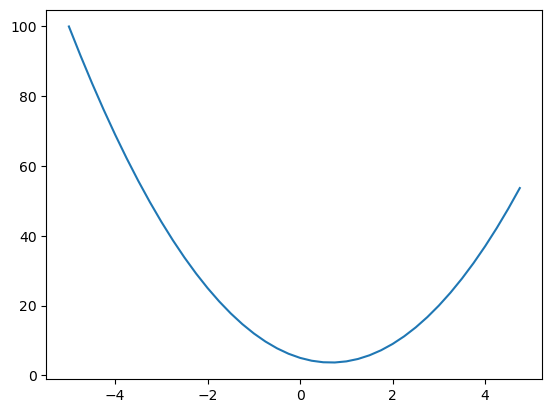

In [557]:
plt.plot(xs,ys)

In [558]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h #estimate derivative

14.00300000000243

In [559]:
#add more variables
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [560]:
#estimate derivative

h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
a += h #try add h on a, b, c, see how the derivative changes
d2 = a*b+c

print("d1: ", d1)
print("d2: ", d2)
print("slope: ", (d2-d1)/h)



d1:  4.0
d2:  3.999699999999999
slope:  -3.000000000010772


In [561]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self*-1

    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data* out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
                node._backward()

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()




In [562]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value(data=-8.0)

In [563]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [564]:
d._op

'+'

In [565]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0*-3.0
b.grad = -2.0*2.0

In [566]:
#conda install python-graphviz
#brew install graphviz
#pip install graphviz

In [567]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }"  % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Value(data=-8.0)


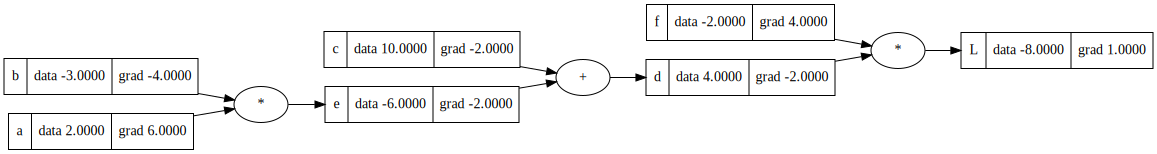

In [568]:
print(L)
draw_dot(L)

In [569]:
 a.data +=0.01 * a.grad
 b.data +=0.01 * b.grad
 c.data +=0.01 * c.grad
 f.data +=0.01 * f.grad

e =a*b
d=e+c
L = d*f

print(L.data)

-7.286496


In [570]:
def lol():

    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e =a*b; e.label='e'
    d=e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e =a*b; e.label='e'
    d=e+c; d.label='d'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

-4.000000000008441


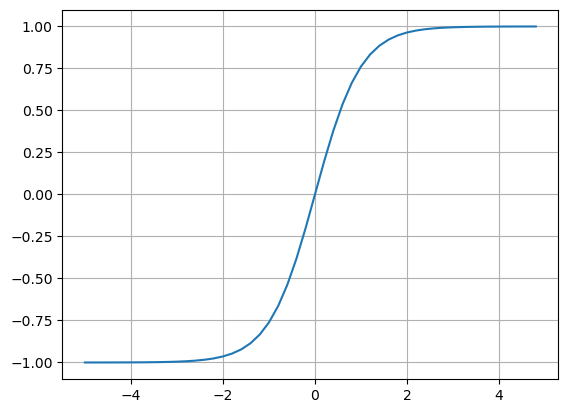

In [571]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [572]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [573]:
o.backward()

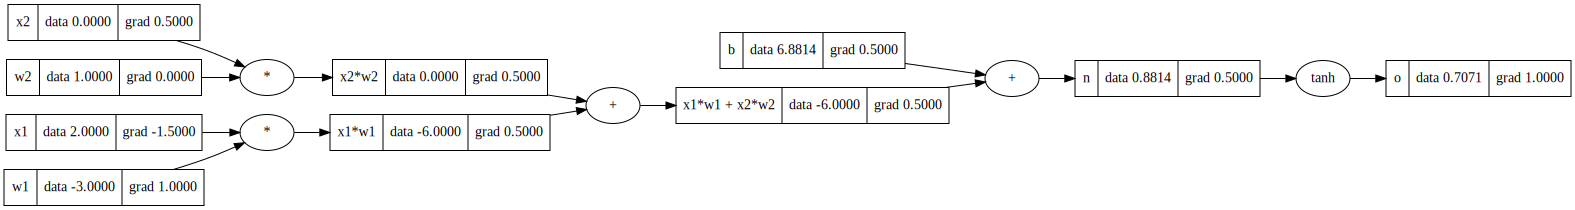

In [574]:
draw_dot(o)

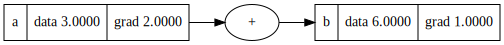

In [575]:
#test a special case where the variable calculate with itself
a = Value(3.0, label='a')
b = a+ a  ; b.label = 'b'
b.backward()
draw_dot(b)

In [576]:
a = Value(2.0)
b = Value(1.0)
a + 1
a * 2
2*a
a-1
a/2
a**-1


Value(data=0.5)

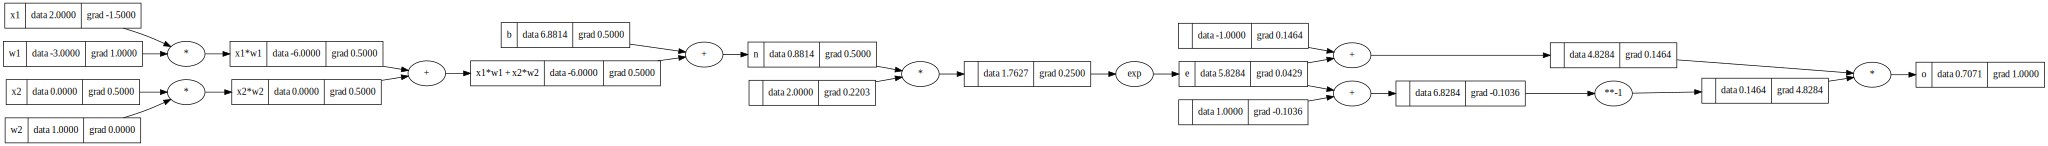

In [577]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#---------
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)


In [578]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#---------
e = (2*n).exp()
e

Value(data=5.828427124746192)

In [579]:
import torch

In [580]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

n = x1*w1 + x2*w2 +b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [581]:
import random
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

 

In [582]:
x = [2.0,3.0, -1]
n = MLP(3,[4,4,1])
n(x)


Value(data=0.773727644760297)

In [583]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.773727644760297),
 Value(data=-0.6709732404403793),
 Value(data=0.408337331567431),
 Value(data=0.7913927867112034)]

In [584]:
n.parameters()

[Value(data=-0.8169120536433834),
 Value(data=0.44313334721495123),
 Value(data=-0.7368435683454639),
 Value(data=0.8679503162003293),
 Value(data=0.34872199778921353),
 Value(data=0.9466819363649674),
 Value(data=-0.07379363571371877),
 Value(data=0.7805231595886384),
 Value(data=-0.2058227786918998),
 Value(data=-0.52785985270496),
 Value(data=0.2577801535811646),
 Value(data=-0.6520826661363355),
 Value(data=0.9633689960796024),
 Value(data=-0.37985231838635136),
 Value(data=0.9903281860598931),
 Value(data=0.9805274484126669),
 Value(data=0.8745399796694622),
 Value(data=0.7425589938336021),
 Value(data=0.9491576507393049),
 Value(data=0.25945736555651777),
 Value(data=0.3381089467456526),
 Value(data=0.679334919366501),
 Value(data=0.2934751198982104),
 Value(data=0.7626449643766153),
 Value(data=-0.24279551697003177),
 Value(data=-0.047207756695606395),
 Value(data=-0.9364807195340217),
 Value(data=-0.6152135724338346),
 Value(data=0.3814870455656545),
 Value(data=0.0062795828408

In [585]:
#define loss function
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.1863887961746165)

In [586]:
loss.backward()

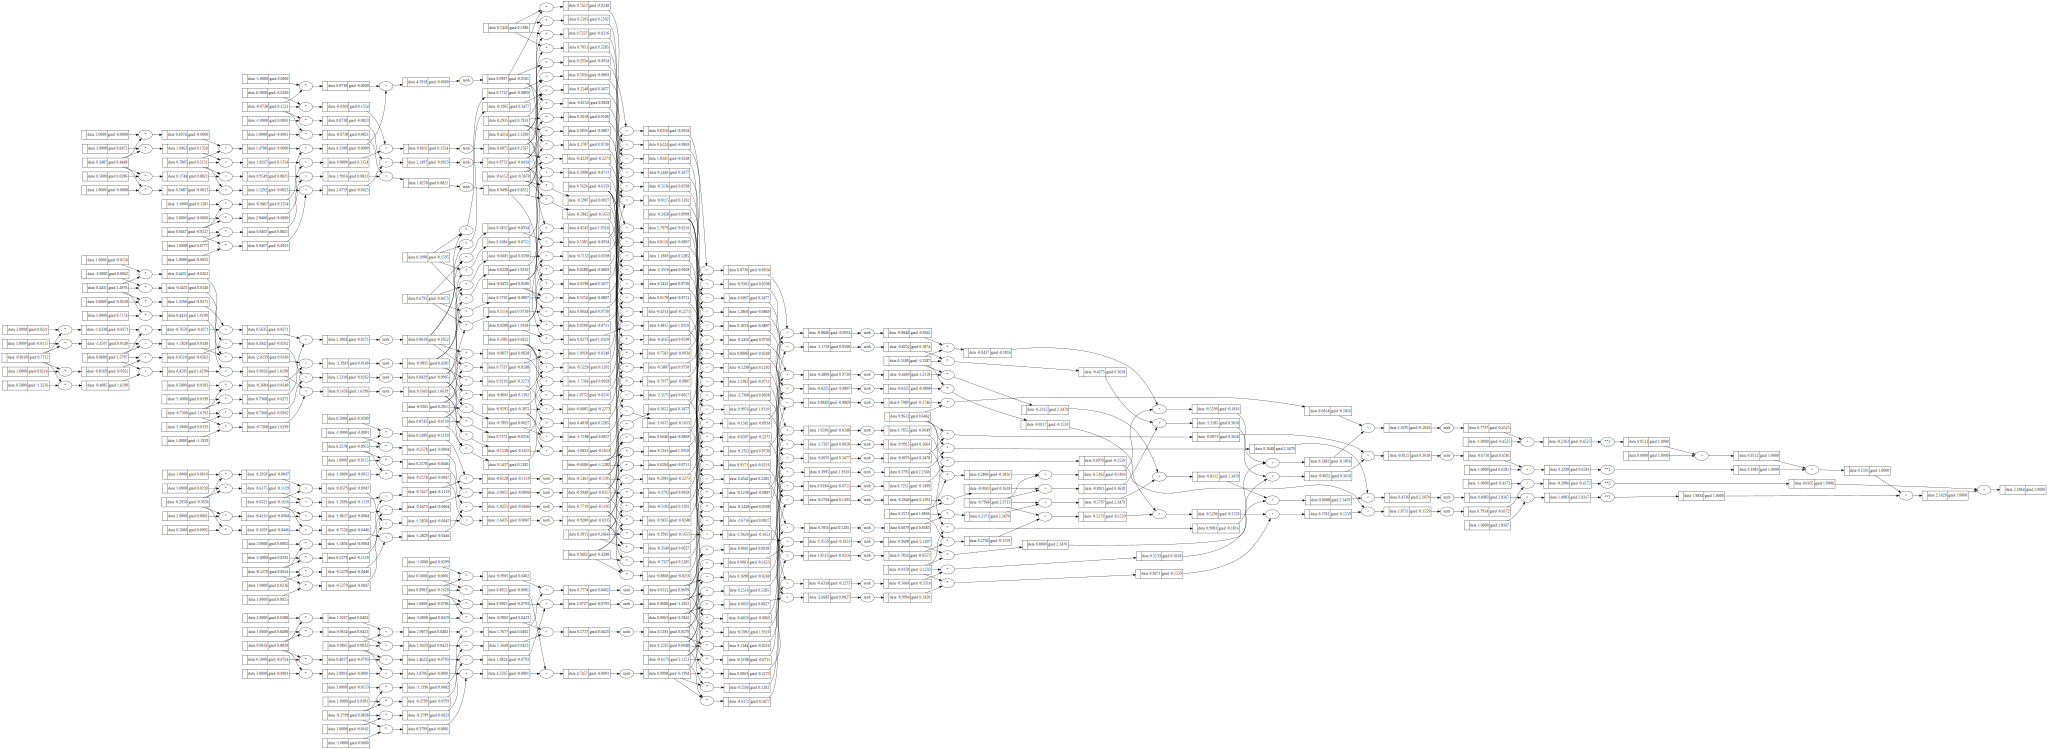

In [587]:
draw_dot(loss)

In [631]:
#tune 100 iterations with learning rate 0.01
for k in range(100):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data+= -0.01 * p.grad #eta = 0.01

    print(k, loss.data)


0 0.013677122602118393
1 0.013598674218749749
2 0.013521085761175715
3 0.01344434341371182
4 0.013368433651885352
5 0.01329334323486005
6 0.013219059198095157
7 0.01314556884622967
8 0.013072859746184252
9 0.013000919720473098
10 0.012929736840718062
11 0.01285929942135839
12 0.012789596013548836
13 0.01272061539923994
14 0.01265234658543413
15 0.012584778798611517
16 0.012517901479319492
17 0.012451704276921048
18 0.012386177044495655
19 0.012321309833888504
20 0.012257092890902155
21 0.012193516650626643
22 0.012130571732903103
23 0.012068248937916444
24 0.012006539241912854
25 0.011945433793038284
26 0.011884923907293565
27 0.011825001064602762
28 0.011765656904990955
29 0.011706883224867624
30 0.011648671973412919
31 0.011591015249062652
32 0.011533905296090049
33 0.011477334501279876
34 0.011421295390693106
35 0.011365780626518569
36 0.011310783004009445
37 0.011256295448501468
38 0.011202311012510714
39 0.011148822872908127
40 0.01109582432816883
41 0.011043308795693707
42 0.0109

In [633]:
ypred

[Value(data=0.9561359714515134),
 Value(data=-0.9883430910711684),
 Value(data=-0.9385495105920139),
 Value(data=0.9469808159855062)]